In [2]:
#Import libraries

import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from flask import Flask, request, jsonify
from keras.preprocessing import image
from keras.models import load_model
from keras.models import save_model

In [5]:
from PIL import Image
from matplotlib import pyplot as plt

In [7]:
def load_data(data_dir):
    images = []
    labels = []

    for filename in os.listdir(os.path.join(data_dir, "images")):
        if filename.endswith('.jpg'):
            img_path = os.path.join(data_dir, "images", filename)
            label_path = os.path.join(data_dir, "labels", filename.replace('.jpg', '.txt'))

            if os.path.isfile(label_path):
                with open(label_path, 'r') as label_file:
                    line = label_file.readline().strip()

                    if not line:
                        print(f"Empty line in file: {label_path}")
                        continue
                        
                    try:
                        label = int(line.split()[0])
                        labels.append(label)
                    except (ValueError, IndexError) as e:
                        print(f"Error processing line in file {label_path}: {line}")
                        print(f"Error details: {e}")

                # Resize the image to the expected input shape (224, 224)
                img = cv2.imread(img_path)
                img = cv2.resize(img, (224, 224))
                images.append(img)

    return np.array(images), np.array(labels)

# Specify your dataset directory
dataset_dir = '/Users/gurl/Desktop/BrainTumorImages/TumorDetectionYolov8/OD8/Brain Tumor Detection/train'

# Load the data
images, labels = load_data(dataset_dir)

Empty line in file: /Users/gurl/Desktop/BrainTumorImages/TumorDetectionYolov8/OD8/Brain Tumor Detection/train/labels/volume_81_slice_74_jpg.rf.0e6fd292529c8de2f2200362c5356e2f.txt
Empty line in file: /Users/gurl/Desktop/BrainTumorImages/TumorDetectionYolov8/OD8/Brain Tumor Detection/train/labels/volume_156_slice_99_jpg.rf.e0d4b9e1099e5e82068e9dd8d7be5d5a.txt
Empty line in file: /Users/gurl/Desktop/BrainTumorImages/TumorDetectionYolov8/OD8/Brain Tumor Detection/train/labels/volume_142_slice_87_jpg.rf.7ff60ed9145d23ded877f35f43c44127.txt
Empty line in file: /Users/gurl/Desktop/BrainTumorImages/TumorDetectionYolov8/OD8/Brain Tumor Detection/train/labels/volume_232_slice_98_jpg.rf.a9f52374f1363f05c627e39af3f4879a.txt
Empty line in file: /Users/gurl/Desktop/BrainTumorImages/TumorDetectionYolov8/OD8/Brain Tumor Detection/train/labels/volume_86_slice_70_jpg.rf.dc460f228a36168dcadb375fa8e17605.txt
Empty line in file: /Users/gurl/Desktop/BrainTumorImages/TumorDetectionYolov8/OD8/Brain Tumor Det

In [8]:
# split dataset into training and testing sets

x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

In [9]:
# Ensure labels start from 0
min_label = np.min(y_train)
y_train = y_train - min_label
y_test = y_test - min_label

# Count the number of unique labels
num_classes = len(np.unique(y_train))

# Convert labels to categorical format
y_train_categorical = to_categorical(y_train, num_classes=num_classes)
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

In [12]:
# Load the pre-trained ResNet50 model without the top layer
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Add custom layers for classification
x = base_model.output
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=output)

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train_categorical, epochs=5, batch_size=30, validation_data=(x_test, y_test_categorical))

# Evaluate the model on the test set
accuracy = model.evaluate(x_test, y_test_categorical)[1]
print(f'Test Accuracy: {accuracy}')

Epoch 1/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 1355s 7s/step - accuracy: 0.6007 - loss: 7.8093 - val_accuracy: 0.6433 - val_loss: 32.3031
Epoch 2/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 1417s 8s/step - accuracy: 0.6694 - loss: 0.7040 - val_accuracy: 0.6754 - val_loss: 3.8639
Epoch 3/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 1468s 8s/step - accuracy: 0.7220 - loss: 0.5834 - val_accuracy: 0.7141 - val_loss: 0.6505
Epoch 4/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 4561s 25s/step - accuracy: 0.7740 - loss: 0.5126 - val_accuracy: 0.7586 - val_loss: 0.5115
Epoch 5/5
183/183 ━━━━━━━━━━━━━━━━━━━━ 1327s 7s/step - accuracy: 0.8236 - loss: 0.4155 - val_accuracy: 0.7826 - val_loss: 0.5888
43/43 ━━━━━━━━━━━━━━━━━━━━ 59s 1s/step - accuracy: 0.7883 - loss: 0.6112
Test Accuracy: 0.7826403975486755


In [13]:
from sklearn.metrics import precision_recall_curve, f1_score, precision_score, recall_score
from keras.utils import to_categorical
from sklearn.preprocessing import label_binarize

43/43 ━━━━━━━━━━━━━━━━━━━━ 54s 1s/step
Label 0:
 Precision: 0.7889105058365758
 Recall: 0.9112359550561798
 F1 Score: 0.8456725755995829
Label 1:
 Precision: 0.7669616519174042
 Recall: 0.5427974947807933
 F1 Score: 0.6356968215158925
Label 2:
 Precision: 0.0
 Recall: 0.0
 F1 Score: 0.0


/Users/gurl/conda-envs/aai/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


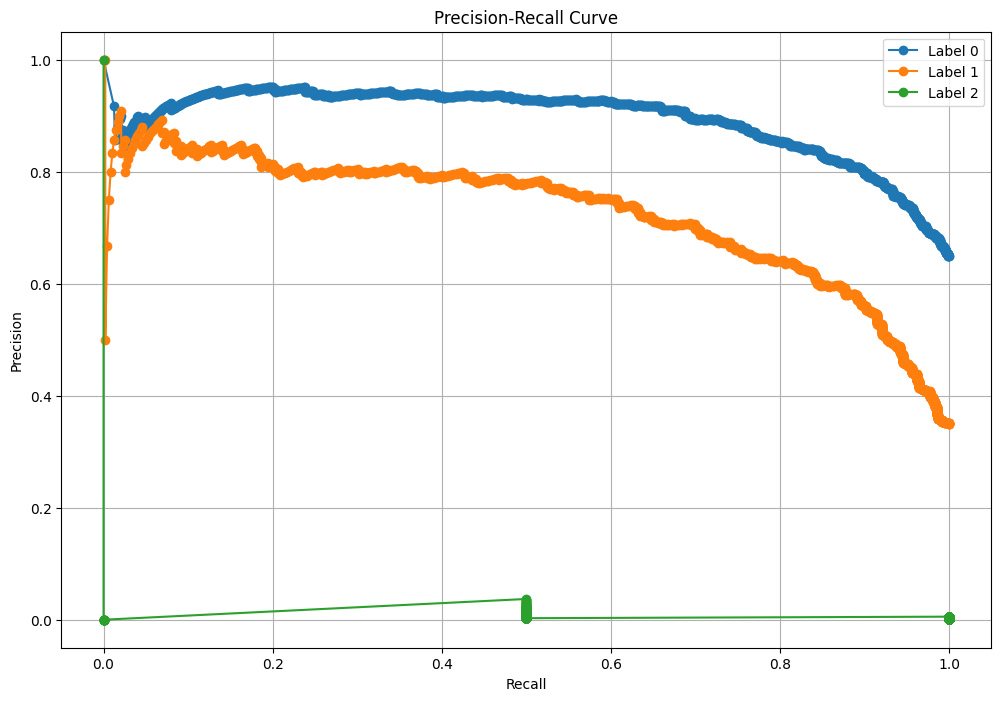

In [16]:
# Predict probabilities on the test set
y_pred_prob = model.predict(x_test)

# Convert the test labels to binary format
y_test_binary = label_binarize(y_test, classes=np.arange(num_classes))

# Compute precision, recall, and F1 score for each class
precision = dict()
recall = dict()
f1 = dict()
for i in range(num_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test_binary[:, i], y_pred_prob[:, i])
    f1[i] = f1_score(y_test_binary[:, i], np.round(y_pred_prob[:, i]))

# Print precision, recall, and F1 scores
for i in range(num_classes):
    print(f'Label {i}:')
    print(f' Precision: {precision_score(y_test_binary[:, i], np.round(y_pred_prob[:, i]))}')
    print(f' Recall: {recall_score(y_test_binary[:, i], np.round(y_pred_prob[:, i]))}')
    print(f' F1 Score: {f1[i]}')

# Plot Precision-Recall curves for each class
plt.figure(figsize=(12, 8))
for i in range(num_classes):
    plt.plot(recall[i], precision[i], marker='o', label=f'Label {i}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc='best')
plt.grid(True)
plt.show()

In [20]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 8))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

# Plot the test set accuracy as a horizontal line
plt.axhline(y=test_accuracy, color='r', linestyle='--', label='Test Accuracy')

plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='best')
plt.grid(True)
plt.show()

NameError: name 'history' is not defined

<Figure size 1200x800 with 0 Axes>